# ANIP Challenge - Task 2: Age Estimation with JAX

**Objective**: Build a robust age estimation model to predict the age of a person from a single image.

**Dataset**:
- Training: 40,000+ images with format `XXXXXX_YZWW.JPG` where:
  - `XXXXXX`: person ID
  - `Y`: photo number (0, 1, 2, ...)
  - `Z`: gender (M or F)
  - `WW`: age (16-99)
- Testing: 200 images (numbered 0-199.JPG)

**Approach**: 
- Regression model using ResNet backbone with JAX/Flax
- Data augmentation for robustness
- Multi-task learning (age + gender auxiliary task)

**References**:
- Rothe, R., Timofte, R., & Van Gool, L. (2015). "DEX: Deep EXpectation of apparent age from a single image." ICCV Workshops.
- Zhang, K., et al. (2017). "Age Group and Gender Estimation in the Wild with Deep RoR Architecture." IEEE Access.
- Flax/JAX Documentation: https://flax.readthedocs.io/

---

## 1. Environment Setup & Configuration

In [1]:
# Detect environment (Kaggle vs Local)
import os
import sys

# Check if running on Kaggle
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    print("🚀 Running on Kaggle")
    DATA_ROOT = '/kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr'
    OUTPUT_DIR = '/kaggle/working'
else:
    print("💻 Running locally")
    # Adjust this path to your local setup
    DATA_ROOT = '/home/guy/Documents/Projects/anip-reconnaissance-faciale-estimation-ages-ocr'
    OUTPUT_DIR = os.path.join(DATA_ROOT, 'output')
    os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Data root: {DATA_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

🚀 Running on Kaggle
Data root: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr
Output directory: /kaggle/working


In [2]:
# Install required packages
import subprocess

def install_packages():
    """Install required packages for JAX-based facial recognition"""
    packages = [
        'jax[cuda]',  # Use jax[cpu] if you do not have GPU
        'flax',
        'optax',
        'pillow',
        'matplotlib',
        'scikit-learn',
        'tqdm',
        'pandas',
        'seaborn',
        'flaxmodels'
    ]
    
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    
    print("✅ All packages installed successfully!")

# Uncomment the line below to install packages (run once)
install_packages()

Installing jax[cuda]...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 44.0 MB/s eta 0:00:00
Installing flax...
Installing optax...
Installing pillow...
Installing matplotlib...
Installing scikit-learn...
Installing tqdm...
Installing pandas...
Installing seaborn...
Installing flaxmodels...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 1.9 MB/s eta 0:00:00
✅ All packages installed successfully!


## 2. Import Libraries

In [3]:
# Suppress common JAX/CUDA warnings
import warnings
import os
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (if using TF backend)
os.environ['JAX_PLATFORMS'] = 'cuda'  # Explicitly set JAX to use CUDA

print("✓ Warning filters configured")

✓ Warning filters configured


In [4]:
try:
    import jax
    import jax.numpy as jnp
    from jax import random, jit
    import flax.linen as nn
    from flax.training import train_state, checkpoints
    import optax

    # Configure JAX for memory efficiency
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

except ImportError:
    print("❌ JAX/Flax not installed!")
    sys.exit(1)

# Try to import pretrained models
try:
    import flaxmodels as fm

    PRETRAINED_AVAILABLE = True
    print("✅ Flaxmodels available - can use pretrained ResNet")
except ImportError:
    PRETRAINED_AVAILABLE = False
    print("⚠️  Flaxmodels not available - using custom architecture")

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict, Any
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import pickle
import gc

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
key = random.PRNGKey(SEED)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

E0000 00:00:1760687903.374653      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760687903.428564      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Flaxmodels available - can use pretrained ResNet
JAX version: 0.5.2
JAX devices: [CudaDevice(id=0)]


## 3. Data Loading & Preprocessing

In [5]:
# Configuration
MIN_AGE = 16
MAX_AGE = 99

USE_PRETRAINED = True  # Set to False if flaxmodels not available
BACKBONE_TYPE = "resnet50"  # 'resnet18', 'resnet34', 'resnet50', 'resnet101'
FREEZE_BACKBONE = False
EMBEDDING_DIM = 128

# Training
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Smaller batch size to prevent OOM
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15  # Fewer epochs with pretrained model
GRADIENT_ACCUMULATION_STEPS = 4  # Simulate larger batch size

# Data
NUM_TRIPLETS = 5000  # Reduced for memory efficiency
VAL_SPLIT = 0.1

# Optimization
MAX_IMAGES_IN_MEMORY = 1000  # Load images in chunks
SAVE_CHECKPOINT_EVERY = 3
EARLY_STOPPING_PATIENCE = 5

# Misc
SEED = 42
SIMILARITY_THRESHOLD = 0.6
REMOVE_BACKGROUND = False  # Set to True to enable background removal
USE_YOLO_DETECTION = False  # Set to True to use YOLO for face detection
YOLO_CONFIDENCE = 0.5  # Minimum confidence for face detection

# Yolo
YOLO_MODEL = "yolov8n.pt"  # Face detection model

# Dataset paths
if IS_KAGGLE:
    TRAIN_DIR = Path(DATA_ROOT) / 'dataset_tache_2' / 'dataset_tache_2' / 'train'
    TEST_DIR = Path(DATA_ROOT) / 'dataset_tache_2' / 'dataset_tache_2' / 'test'
else:
    TRAIN_DIR = Path(DATA_ROOT) / 'dataset_tache_2' / 'dataset_tache_2' / 'train'
    TEST_DIR = Path(DATA_ROOT) / 'dataset_tache_2' / 'dataset_tache_2' / 'test'

print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Train dir exists: {TRAIN_DIR.exists()}")
print(f"Test dir exists: {TEST_DIR.exists()}")

Train directory: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr/dataset_tache_2/dataset_tache_2/train
Test directory: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr/dataset_tache_2/dataset_tache_2/test
Train dir exists: True
Test dir exists: True


In [6]:
import re

def parse_filename(filename: str) -> Tuple[str, int, str, int]:
    """
    Parse training filename: XXXXXX_YZWW.JPG
    Returns: (person_id, photo_num, gender, age)
    """
    name = filename.stem
    
    # Split by underscore    
    pattern = r'(?P<identifiant>\w+?)_(?P<num_photo>\d+)(?P<sexe>[MF])(?P<age>\d{2})'
    
    match = re.match(pattern, name)
    person_id, photo_num, gender, age = None, None, None, None
    if match:
        out = match.groupdict()
        person_id, photo_num, gender, age = out.values()
        # Convert numeric values to integers
        photo_num = int(photo_num)
        age = int(age)

    
    return person_id, photo_num, gender, age

def load_and_preprocess_image(image_path: str, size: Tuple[int, int] = IMG_SIZE, augment: bool = False) -> np.ndarray:
    """Load and preprocess a single image with optional augmentation"""
    img = Image.open(image_path).convert('RGB')
    
    # Data augmentation for training
    if augment:
        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Random rotation (-10 to 10 degrees)
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-10, 10)
            img = img.rotate(angle, fillcolor=(128, 128, 128))
    
    img = img.resize(size, Image.LANCZOS)
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    # Normalize using ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_array = (img_array - mean) / std
    
    return img_array

def parse_train_dataset(train_dir: Path, num_samples: int = 2000) -> pd.DataFrame:
    """Parse training dataset and create DataFrame"""
    data = []
    
    train_files = sorted(list(train_dir.glob('*.JPG')))
    
    # Shuffle all files first, then take subset
    np.random.shuffle(train_files)
    selected_files = train_files[:num_samples]
    
    print(f"Total available images: {len(train_files)}")
    print(f"Selected {len(selected_files)} images for training (shuffled)")
    
    for img_path in tqdm(selected_files, desc="Parsing images"):
        try:
            person_id, photo_num, gender, age = parse_filename(img_path)
            data.append({
                'path': str(img_path),
                'person_id': person_id,
                'photo_num': photo_num,
                'gender': gender,
                'age': age,
                'gender_encoded': 0 if gender == 'M' else 1
            })
        except Exception as e:
            print(f"Error parsing {img_path.name}: {e}")
            continue
    
    df = pd.DataFrame(data)
    return df

# Load training data (adjust num_samples as needed: 1000, 2000, 4000, etc.)
train_df = parse_train_dataset(TRAIN_DIR, num_samples=2000)
print(f"\nTotal training samples: {len(train_df)}")
print(f"Unique persons: {train_df['person_id'].nunique()}")
print(f"Age range: {train_df['age'].min()} - {train_df['age'].max()}")
print(f"Gender distribution:\n{train_df['gender'].value_counts()}")
print(f"\nFirst few rows:")
print(train_df.head())

Total available images: 40012
Selected 2000 images for training (shuffled)


Parsing images: 100%|██████████| 2000/2000 [00:00<00:00, 201436.17it/s]


Total training samples: 2000
Unique persons: 1872
Age range: 16 - 71
Gender distribution:
gender
M    1740
F     260
Name: count, dtype: int64

First few rows:
                                                path person_id  photo_num  \
0  /kaggle/input/anip-reconnaissance-faciale-esti...     24542          5   
1  /kaggle/input/anip-reconnaissance-faciale-esti...    300189          4   
2  /kaggle/input/anip-reconnaissance-faciale-esti...    051289          1   
3  /kaggle/input/anip-reconnaissance-faciale-esti...    091475          4   
4  /kaggle/input/anip-reconnaissance-faciale-esti...    301817          4   

  gender  age  gender_encoded  
0      M   17               0  
1      M   19               0  
2      M   46               0  
3      M   37               0  
4      M   27               0  


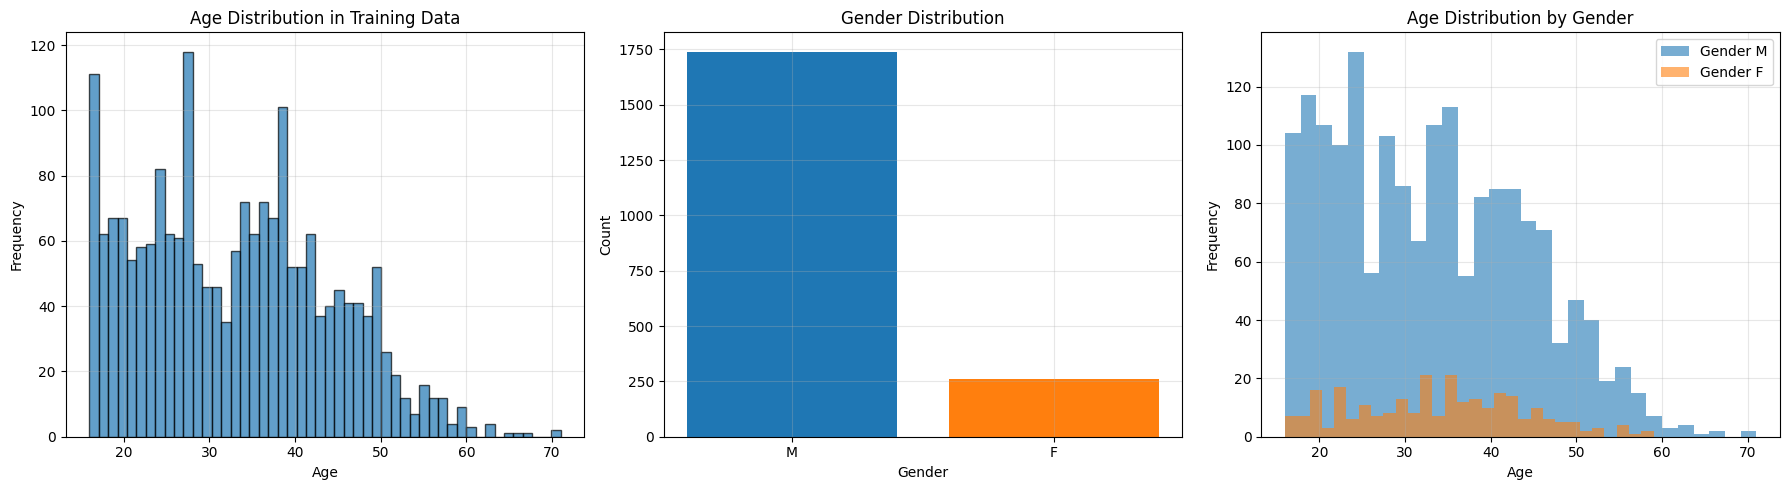

In [7]:
# Visualize age distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age histogram
axes[0].hist(train_df['age'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution in Training Data')
axes[0].grid(True, alpha=0.3)

# Gender distribution
gender_counts = train_df['gender'].value_counts()
axes[1].bar(gender_counts.index, gender_counts.values, color=['#1f77b4', '#ff7f0e'])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].set_title('Gender Distribution')
axes[1].grid(True, alpha=0.3)

# Age by gender
for gender in ['M', 'F']:
    ages = train_df[train_df['gender'] == gender]['age']
    axes[2].hist(ages, bins=30, alpha=0.6, label=f'Gender {gender}')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Age Distribution by Gender')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'age_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

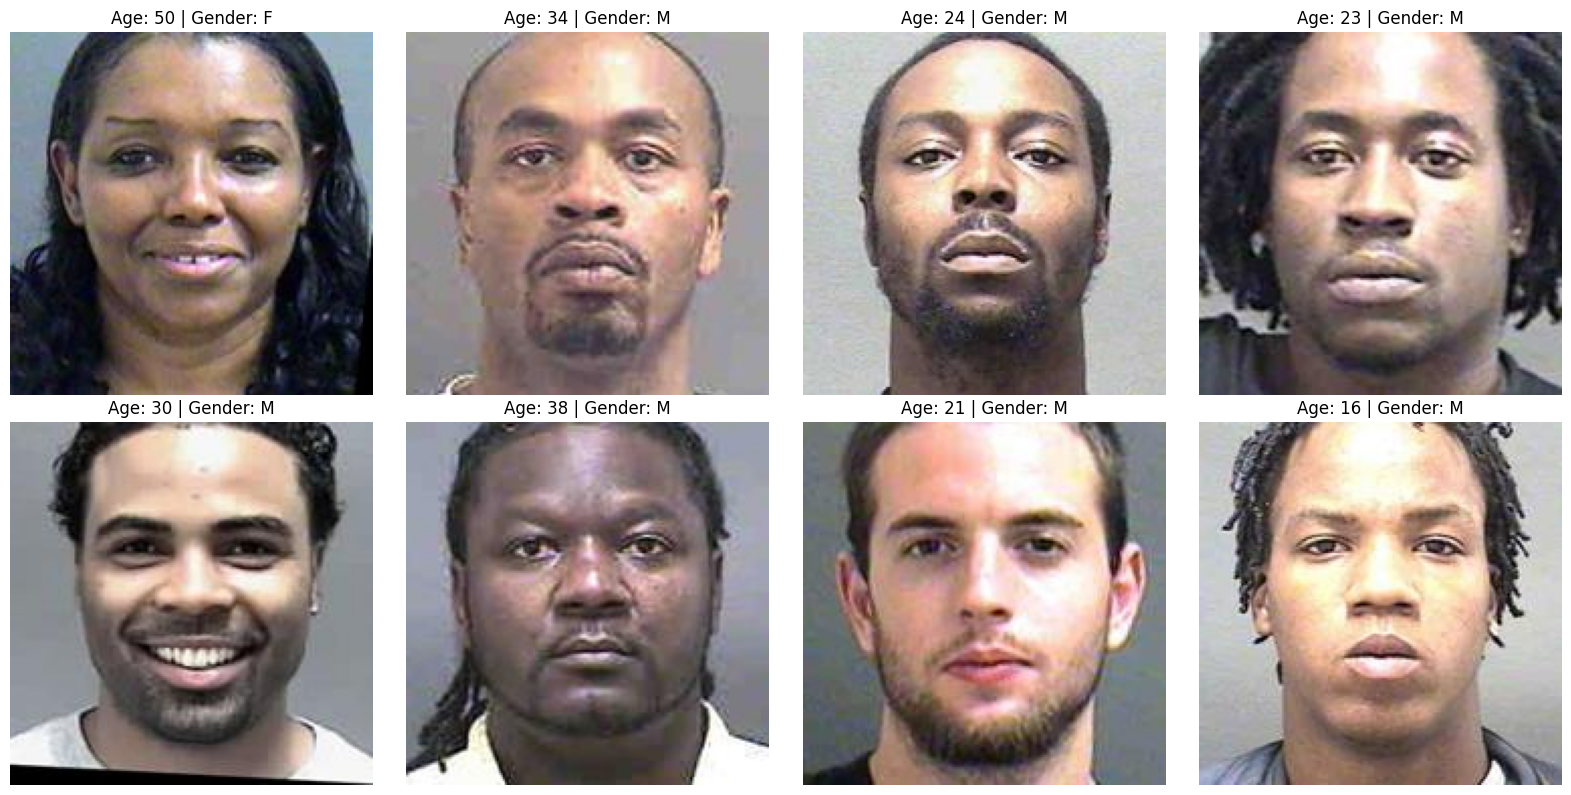

In [8]:
# Visualize sample images
def visualize_samples(df: pd.DataFrame, num_samples: int = 8):
    """Visualize random sample images with labels"""
    samples = df.sample(n=num_samples, random_state=SEED)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img = Image.open(row['path'])
        axes[i].imshow(img)
        axes[i].set_title(f"Age: {row['age']} | Gender: {row['gender']}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(train_df, num_samples=8)

## 4. Model Architecture (JAX/Flax)

We use a ResNet-inspired architecture with:
- Convolutional blocks with BatchNorm and ReLU
- Global Average Pooling
- Multi-task output: age regression + gender classification (auxiliary task)

**Reference**: He, K., et al. (2016). "Deep Residual Learning for Image Recognition." CVPR.

In [9]:
class ConvBlock(nn.Module):
    features: int
    kernel_size: Tuple[int, int] = (3, 3)
    strides: Tuple[int, int] = (1, 1)

    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Conv(
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding="SAME",
        )(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        return x


class ResNetBackbone(nn.Module):
    """ResNet backbone for feature extraction"""

    backbone_type: str = "resnet50"
    pretrained: bool = True

    @nn.compact
    def __call__(self, x, training: bool = True):
        if self.pretrained and PRETRAINED_AVAILABLE:
            try:
                if self.backbone_type == "resnet50":
                    backbone = fm.ResNet50(output="activations", pretrained="imagenet")
                elif self.backbone_type == "resnet34":
                    backbone = fm.ResNet34(output="activations", pretrained="imagenet")
                elif self.backbone_type == "resnet18":
                    backbone = fm.ResNet18(output="activations", pretrained="imagenet")
                else:
                    backbone = fm.ResNet101(output="activations", pretrained="imagenet")

                # When output="activations", ResNet returns a dict of activations
                activations_dict = backbone(x, train=training)

                # Get the last activation layer (avg_pool output)
                # The dict contains keys like 'conv1', 'bn1', 'act1', 'max_pool',
                # 'block1', 'block2', etc., and 'avg_pool' for the final pooled features
                if "avg_pool" in activations_dict:
                    features = activations_dict["avg_pool"]
                else:
                    # Fallback: get the last item in the dict
                    features = list(activations_dict.values())[-1]

                # If features are still 4D (B, H, W, C), apply global average pooling
                if len(features.shape) == 4:
                    features = jnp.mean(features, axis=(1, 2))

                return features
            except Exception as e:
                print(f"⚠️  Error loading pretrained model: {e}")
                print("   Falling back to custom architecture")

        # Custom ResNet-like architecture
        x = nn.Conv(features=64, kernel_size=(7, 7), strides=(2, 2), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding="SAME")

        # Residual blocks
        for features in [64, 128, 256, 512]:
            x = self._residual_block(x, features, training)
            x = self._residual_block(x, features, training)

        features = jnp.mean(x, axis=(1, 2))
        return features

    def _residual_block(self, x, features, training):
        shortcut = x
        if x.shape[-1] != features:
            shortcut = nn.Conv(features=features, kernel_size=(1, 1))(shortcut)
            shortcut = nn.BatchNorm(use_running_average=not training)(shortcut)

        x = nn.Conv(features=features, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Conv(features=features, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)

        x = x + shortcut
        x = nn.relu(x)
        return x

class AgeGenderEstimator(nn.Module):
    """Multi-task model for age estimation and gender classification"""
    
    embedding_dim: int = 128
    use_pretrained: bool = False
    backbone_type: str = "resnet50"
    freeze_backbone: bool = False

    @nn.compact
    def __call__(self, x, training: bool = True):
        if self.use_pretrained:
            features = ResNetBackbone(
                backbone_type=self.backbone_type, pretrained=True
            )(x, training=training and not self.freeze_backbone)
        else:
            # Lightweight custom architecture
            x = ConvBlock(features=64, kernel_size=(7, 7), strides=(2, 2))(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=128)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=256)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=512)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            features = jnp.mean(x, axis=(1, 2))

        # Channel attention
        attention_weights = nn.Dense(features=features.shape[-1])(features)
        attention_weights = nn.sigmoid(attention_weights)
        features = features * attention_weights  # Element-wise
        
        # Shared features
        x = nn.Dense(features=512)(features)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        
        # Age regression head
        age = nn.Dense(features=256)(x)
        age = nn.relu(age)
        age = nn.Dense(features=1)(age)  # Single output for age
        age = jnp.squeeze(age, axis=-1)
        
        # Gender classification head (auxiliary task)
        gender = nn.Dense(features=self.embedding_dim)(x)
        gender = nn.relu(gender)
        gender = nn.Dense(features=2)(gender)  # Binary classification
        
        return age, gender

# Initialize model
model = AgeGenderEstimator(
        embedding_dim=EMBEDDING_DIM,
        use_pretrained=USE_PRETRAINED and PRETRAINED_AVAILABLE,
        backbone_type=BACKBONE_TYPE,
        freeze_backbone=FREEZE_BACKBONE,
)

# Test model initialization
key, init_key = random.split(key)
dummy_input = jnp.ones((1, *IMG_SIZE, 3))
variables = model.init(init_key, dummy_input, training=False)

print("Model initialized successfully!")
print(f"Model parameters: {sum(x.size for x in jax.tree_util.tree_leaves(variables))}")

# Test forward pass
age_pred, gender_pred = model.apply(variables, dummy_input, training=False)
print(f"Age prediction shape: {age_pred.shape}")
print(f"Gender prediction shape: {gender_pred.shape}")

Downloading: "https://www.dropbox.com/s/fcc8iii38ezvqog/resnet50_weights.h5" to /tmp/flaxmodels/resnet50_weights.h5


100%|██████████| 103M/103M [00:03<00:00, 30.0MiB/s]


Model initialized successfully!
Model parameters: 27321171
Age prediction shape: (1,)
Gender prediction shape: (1, 2)


## 5. Training Setup

We use:
- **Age loss**: Mean Absolute Error (MAE) for robustness to outliers
- **Gender loss**: Cross-entropy (auxiliary task to improve feature learning)
- **Combined loss**: Weighted sum of both losses

**Reference**: Geng, X., et al. (2013). "Automatic Age Estimation Based on Facial Aging Patterns." IEEE TPAMI.

In [10]:
def compute_loss(age_pred, gender_pred, age_true, gender_true, alpha=0.1):
    """
    Compute combined loss:
    - Age: MAE (Mean Absolute Error)
    - Gender: Cross-entropy (auxiliary task)
    - alpha: weight for gender loss
    """
    # Age loss (MAE)
    age_loss = jnp.mean(jnp.abs(age_pred - age_true))
    
    # Gender loss (cross-entropy)
    gender_loss = optax.softmax_cross_entropy_with_integer_labels(
        gender_pred, gender_true
    ).mean()
    
    # Combined loss
    total_loss = age_loss + alpha * gender_loss
    
    return total_loss, age_loss, gender_loss

@jit
def train_step(state, batch, dropout_key):
    """Single training step"""
    images, ages, genders = batch
    
    def loss_fn(params):
        # Apply model with mutable batch_stats
        result = model.apply(
            {'params': params, 'batch_stats': state.batch_stats},
            images, training=True,
            rngs={'dropout': dropout_key},
            mutable=['batch_stats']
        )
        
        # Extract outputs and updates
        (age_pred, gender_pred), updates = result
        batch_stats = updates['batch_stats']
        
        # Compute loss
        total_loss, age_loss, gender_loss = compute_loss(
            age_pred, gender_pred, ages, genders
        )
        
        return total_loss, (age_loss, gender_loss, batch_stats)
    
    (loss, (age_loss, gender_loss, batch_stats)), grads = jax.value_and_grad(
        loss_fn, has_aux=True
    )(state.params)
    
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=batch_stats)
    
    return state, loss, age_loss, gender_loss

# Create training state
class TrainState(train_state.TrainState):
    batch_stats: Any

# Initialize optimizer with learning rate schedule
schedule = optax.exponential_decay(
    init_value=LEARNING_RATE,
    transition_steps=1000,
    decay_rate=0.95
)
tx = optax.adam(learning_rate=schedule)

state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
    batch_stats=variables.get('batch_stats', {})
)

print("Training state initialized!")

Training state initialized!


In [11]:
def create_batches(df: pd.DataFrame, batch_size: int, augment: bool = False):
    """Create batches from dataframe"""
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        batch_indices = indices[start_idx:end_idx]
        batch_df = df.iloc[batch_indices]
        
        # Load images
        images = []
        for path in batch_df['path']:
            img = load_and_preprocess_image(path, augment=augment)
            images.append(img)
        
        images = np.array(images)
        ages = batch_df['age'].values.astype(np.float32)
        genders = batch_df['gender_encoded'].values.astype(np.int32)
        
        yield (images, ages, genders)
        
        # Free memory
        del images
        gc.collect()

print("Batch creation function ready!")

Batch creation function ready!


## 6. Training Loop

In [12]:
# Split data into train and validation
train_df_split, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED)

print(f"Training samples: {len(train_df_split)}")
print(f"Validation samples: {len(val_df)}")

# Training history
history = {
    'train_loss': [], 'train_age_loss': [], 'train_gender_loss': [],
    'val_loss': [], 'val_age_loss': [], 'val_gender_loss': [],
    'val_mae': []
}

best_val_mae = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Training
    train_losses = []
    train_age_losses = []
    train_gender_losses = []
    key, dropout_key = random.split(key)
    
    pbar = tqdm(
        create_batches(train_df_split, BATCH_SIZE, augment=True),
        desc=f"Training",
        total=len(train_df_split)//BATCH_SIZE
    )
    
    for batch in pbar:
        state, loss, age_loss, gender_loss = train_step(state, batch, dropout_key)
        train_losses.append(float(loss))
        train_age_losses.append(float(age_loss))
        train_gender_losses.append(float(gender_loss))
        pbar.set_postfix({
            'loss': f'{np.mean(train_losses):.4f}',
            'age_mae': f'{np.mean(train_age_losses):.4f}'
        })
    
    avg_train_loss = np.mean(train_losses)
    avg_train_age_loss = np.mean(train_age_losses)
    avg_train_gender_loss = np.mean(train_gender_losses)
    
    history['train_loss'].append(avg_train_loss)
    history['train_age_loss'].append(avg_train_age_loss)
    history['train_gender_loss'].append(avg_train_gender_loss)
    
    # Validation
    val_losses = []
    val_age_losses = []
    val_gender_losses = []
    all_age_preds = []
    all_age_true = []
    
    for batch in create_batches(val_df, BATCH_SIZE, augment=False):
        images, ages, genders = batch
        
        age_pred, gender_pred = model.apply(
            {'params': state.params, 'batch_stats': state.batch_stats},
            images, training=False
        )
        
        total_loss, age_loss, gender_loss = compute_loss(
            age_pred, gender_pred, ages, genders
        )
        
        val_losses.append(float(total_loss))
        val_age_losses.append(float(age_loss))
        val_gender_losses.append(float(gender_loss))
        
        all_age_preds.extend(np.array(age_pred))
        all_age_true.extend(ages)
    
    avg_val_loss = np.mean(val_losses)
    avg_val_age_loss = np.mean(val_age_losses)
    avg_val_gender_loss = np.mean(val_gender_losses)
    val_mae = mean_absolute_error(all_age_true, all_age_preds)
    
    history['val_loss'].append(avg_val_loss)
    history['val_age_loss'].append(avg_val_age_loss)
    history['val_gender_loss'].append(avg_val_gender_loss)
    history['val_mae'].append(val_mae)
    
    print(f"\nTrain Loss: {avg_train_loss:.4f} | Train Age MAE: {avg_train_age_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Age MAE: {val_mae:.4f}")
    
    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        checkpoint_path = os.path.join(OUTPUT_DIR, 'best_model_task2')
        checkpoints.save_checkpoint(checkpoint_path, state, epoch+1, keep=1)
        print(f"✅ Best model saved! (Val MAE: {val_mae:.4f})")
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch_{epoch+1}_task2')
        checkpoints.save_checkpoint(checkpoint_path, state, epoch+1, keep=2)
    
    # Clear memory
    gc.collect()

print("\n✅ Training completed!")

Training samples: 1700
Validation samples: 300

Epoch 1/15


Training: 213it [02:43,  1.31it/s, loss=8.6420, age_mae=8.5980]



Train Loss: 8.6420 | Train Age MAE: 8.5980
Val Loss: 6.4434 | Val Age MAE: 6.4267
✅ Best model saved! (Val MAE: 6.4267)

Epoch 2/15


Training: 213it [01:58,  1.80it/s, loss=5.7487, age_mae=5.7100]



Train Loss: 5.7487 | Train Age MAE: 5.7100
Val Loss: 4.7212 | Val Age MAE: 4.6680
✅ Best model saved! (Val MAE: 4.6680)

Epoch 3/15


Training: 213it [01:58,  1.80it/s, loss=5.1958, age_mae=5.1588]



Train Loss: 5.1958 | Train Age MAE: 5.1588
Val Loss: 9.2327 | Val Age MAE: 9.1828

Epoch 4/15


Training: 213it [01:58,  1.80it/s, loss=4.9853, age_mae=4.9498]



Train Loss: 4.9853 | Train Age MAE: 4.9498
Val Loss: 4.5122 | Val Age MAE: 4.4594
✅ Best model saved! (Val MAE: 4.4594)

Epoch 5/15


Training: 213it [01:58,  1.80it/s, loss=4.6111, age_mae=4.5768]



Train Loss: 4.6111 | Train Age MAE: 4.5768
Val Loss: 5.6863 | Val Age MAE: 5.6287

Epoch 6/15


Training: 213it [01:58,  1.79it/s, loss=4.3393, age_mae=4.3054]



Train Loss: 4.3393 | Train Age MAE: 4.3054
Val Loss: 4.2238 | Val Age MAE: 4.2165
✅ Best model saved! (Val MAE: 4.2165)

Epoch 7/15


Training: 213it [01:59,  1.78it/s, loss=4.0152, age_mae=3.9783]



Train Loss: 4.0152 | Train Age MAE: 3.9783
Val Loss: 4.6023 | Val Age MAE: 4.6022

Epoch 8/15


Training: 213it [01:59,  1.78it/s, loss=3.9405, age_mae=3.9085]



Train Loss: 3.9405 | Train Age MAE: 3.9085
Val Loss: 5.1745 | Val Age MAE: 5.1802

Epoch 9/15


Training: 213it [02:00,  1.77it/s, loss=3.8743, age_mae=3.8415]



Train Loss: 3.8743 | Train Age MAE: 3.8415
Val Loss: 3.8033 | Val Age MAE: 3.7869
✅ Best model saved! (Val MAE: 3.7869)

Epoch 10/15


Training: 213it [01:59,  1.78it/s, loss=3.6842, age_mae=3.6509]



Train Loss: 3.6842 | Train Age MAE: 3.6509
Val Loss: 4.6485 | Val Age MAE: 4.6272

Epoch 11/15


Training: 213it [01:59,  1.78it/s, loss=3.6123, age_mae=3.5799]



Train Loss: 3.6123 | Train Age MAE: 3.5799
Val Loss: 6.1221 | Val Age MAE: 6.0985

Epoch 12/15


Training: 213it [01:59,  1.78it/s, loss=3.1451, age_mae=3.1161]



Train Loss: 3.1451 | Train Age MAE: 3.1161
Val Loss: 4.4693 | Val Age MAE: 4.4546

Epoch 13/15


Training: 213it [01:59,  1.79it/s, loss=3.1801, age_mae=3.1523]



Train Loss: 3.1801 | Train Age MAE: 3.1523
Val Loss: 4.8409 | Val Age MAE: 4.8608

Epoch 14/15


Training: 213it [01:59,  1.78it/s, loss=3.0937, age_mae=3.0652]



Train Loss: 3.0937 | Train Age MAE: 3.0652
Val Loss: 3.7579 | Val Age MAE: 3.7304
✅ Best model saved! (Val MAE: 3.7304)

Epoch 15/15


Training: 213it [02:00,  1.77it/s, loss=3.1276, age_mae=3.1003]



Train Loss: 3.1276 | Train Age MAE: 3.1003
Val Loss: 3.7400 | Val Age MAE: 3.7442

✅ Training completed!


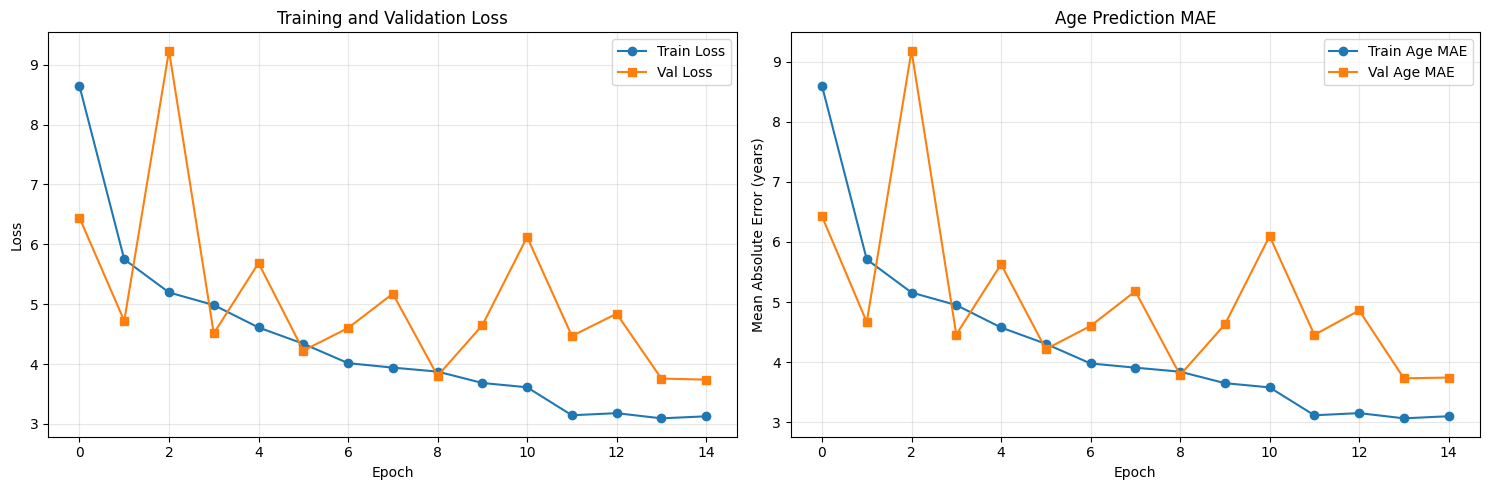

Best Validation MAE: 3.7304 years


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE curves
axes[1].plot(history['train_age_loss'], label='Train Age MAE', marker='o')
axes[1].plot(history['val_mae'], label='Val Age MAE', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error (years)')
axes[1].set_title('Age Prediction MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history_task2.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Best Validation MAE: {best_val_mae:.4f} years")

## 7. Inference on Test Set

In [14]:
# Load test images
test_paths = sorted([str(p) for p in TEST_DIR.glob('*.JPG')])
print(f"Total test images: {len(test_paths)}")

def predict_ages(image_paths: List[str], state, batch_size: int = 32) -> np.ndarray:
    """Predict ages for a list of images"""
    age_predictions = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Predicting ages"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = np.array([load_and_preprocess_image(p) for p in batch_paths])
        
        age_pred, _ = model.apply(
            {'params': state.params, 'batch_stats': state.batch_stats},
            batch_images, training=False
        )
        
        age_predictions.extend(np.array(age_pred))
        
        del batch_images
        gc.collect()
    
    return np.array(age_predictions)

# Predict ages for test set
test_age_predictions = predict_ages(test_paths, state)

# Clip predictions to valid age range
test_age_predictions = np.clip(test_age_predictions, MIN_AGE, MAX_AGE)

print(f"\nTest predictions shape: {test_age_predictions.shape}")
print(f"Age range in predictions: {test_age_predictions.min():.1f} - {test_age_predictions.max():.1f}")
print(f"Mean predicted age: {test_age_predictions.mean():.1f}")
print(f"Std predicted age: {test_age_predictions.std():.1f}")

Total test images: 200


Predicting ages: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Test predictions shape: (200,)
Age range in predictions: 16.0 - 51.4
Mean predicted age: 30.9
Std predicted age: 7.7


## 8. Generate Submission File

Create submission in JSON format: `{"image_name": age, ...}`

In [15]:
def create_submission(test_paths: List[str], predictions: np.ndarray, output_format='json'):
    """
    Create submission file
    Format: {"0.JPG": 25, "1.JPG": 34, ...}
    """
    submission = {}
    
    for path, age in zip(test_paths, predictions):
        image_name = Path(path).name
        # Round age to nearest integer
        submission[image_name] = int(round(age))
    
    print(f"Created {len(submission)} predictions")
    print(f"Sample predictions:")
    for i, (name, age) in enumerate(list(submission.items())[:5]):
        print(f"  {name}: {age} years")
    
    # Save submission
    if output_format == 'json':
        output_path = os.path.join(OUTPUT_DIR, 'submission_task2.json')
        with open(output_path, 'w') as f:
            json.dump(submission, f, indent=2)
    else:  # CSV format
        output_path = os.path.join(OUTPUT_DIR, 'submission_task2.csv')
        df = pd.DataFrame(list(submission.items()), columns=['image', 'age'])
        df.to_csv(output_path, index=False)
    
    print(f"\n✅ Submission saved to: {output_path}")
    return submission

# Create submission (adjust format as needed: 'json' or 'csv')
submission = create_submission(test_paths, test_age_predictions, output_format='json')

Created 200 predictions
Sample predictions:
  0.JPG: 20 years
  1.JPG: 25 years
  10.JPG: 30 years
  100.JPG: 38 years
  101.JPG: 30 years

✅ Submission saved to: /kaggle/working/submission_task2.json


## 9. Visualization & Analysis

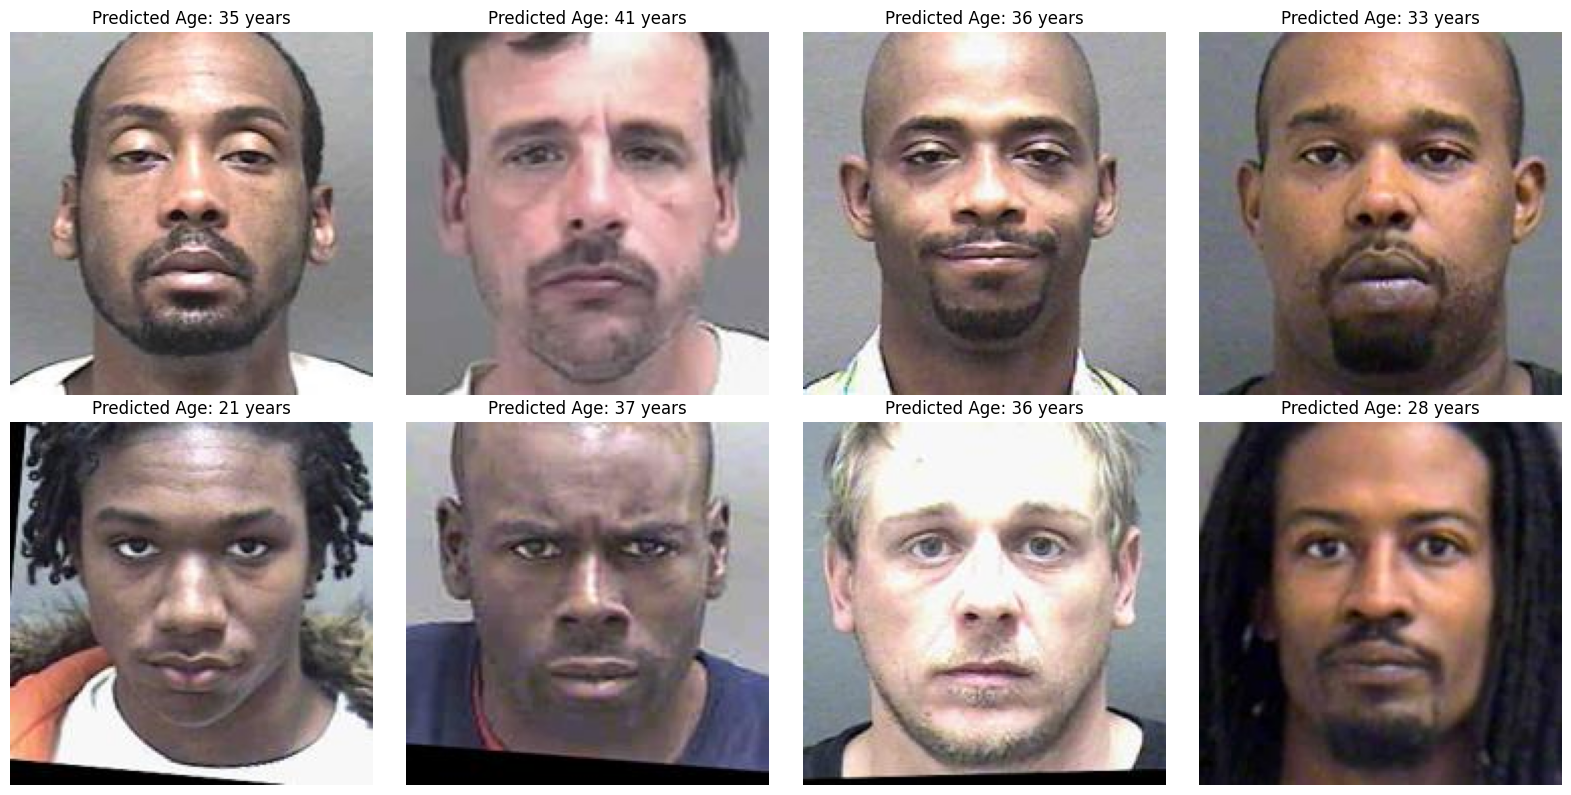

In [16]:
# Visualize predictions on test images
def visualize_predictions(test_paths: List[str], predictions: np.ndarray, num_samples: int = 8):
    """Visualize test predictions"""
    indices = np.random.choice(len(test_paths), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img = Image.open(test_paths[idx])
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted Age: {int(round(predictions[idx]))} years")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'test_predictions_task2.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(test_paths, test_age_predictions, num_samples=8)

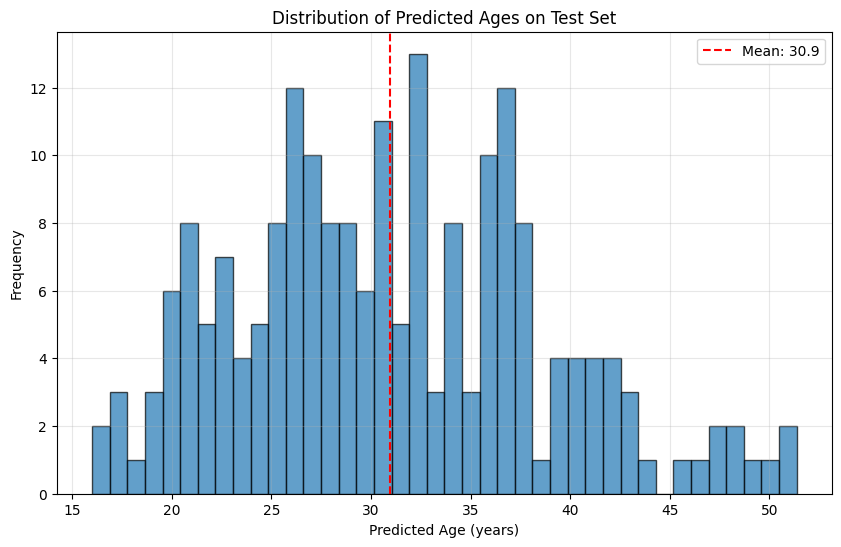

In [17]:
# Distribution of predicted ages
plt.figure(figsize=(10, 6))
plt.hist(test_age_predictions, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Age (years)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ages on Test Set')
plt.axvline(test_age_predictions.mean(), color='red', linestyle='--', 
            label=f'Mean: {test_age_predictions.mean():.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'predicted_age_distribution_task2.png'), dpi=150, bbox_inches='tight')
plt.show()


Validation Set Performance Analysis:


Predicting ages: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Mean Absolute Error (MAE): 3.74 years
Root Mean Squared Error (RMSE): 4.89 years


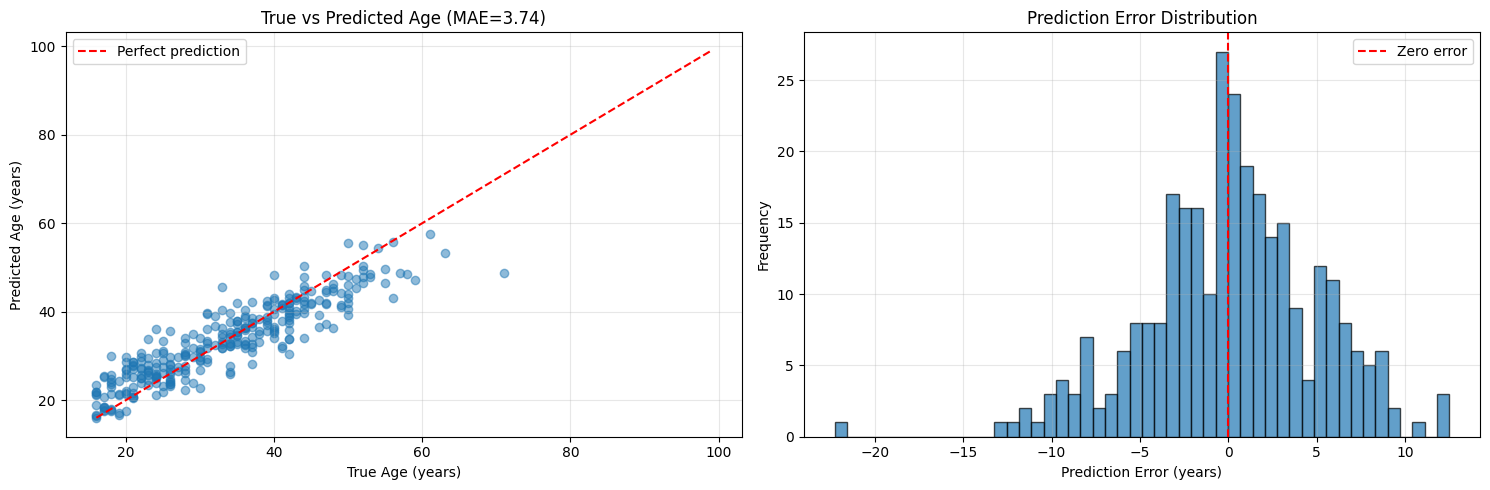

In [18]:
# Validation set analysis (if available)
print("\nValidation Set Performance Analysis:")
print("="*60)

# Get predictions on validation set
val_paths = val_df['path'].tolist()
val_true_ages = val_df['age'].values
val_predictions = predict_ages(val_paths, state, batch_size=32)

# Calculate metrics
mae = mean_absolute_error(val_true_ages, val_predictions)
rmse = np.sqrt(mean_squared_error(val_true_ages, val_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f} years")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} years")

# Error distribution
errors = val_predictions - val_true_ages

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: True vs Predicted
axes[0].scatter(val_true_ages, val_predictions, alpha=0.5)
axes[0].plot([MIN_AGE, MAX_AGE], [MIN_AGE, MAX_AGE], 'r--', label='Perfect prediction')
axes[0].set_xlabel('True Age (years)')
axes[0].set_ylabel('Predicted Age (years)')
axes[0].set_title(f'True vs Predicted Age (MAE={mae:.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Prediction Error (years)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'validation_analysis_task2.png'), dpi=150, bbox_inches='tight')
plt.show()

## 10. Save Model Weights

In [19]:
# Save final model weights
weights_path = os.path.join(OUTPUT_DIR, 'model_weights_task2.pkl')

with open(weights_path, 'wb') as f:
    pickle.dump({
        'params': state.params,
        'batch_stats': state.batch_stats,
        'config': {
            'img_size': IMG_SIZE,
            'min_age': MIN_AGE,
            'max_age': MAX_AGE,
        },
        'history': history,
        'best_val_mae': best_val_mae
    }, f)

print(f"Model weights saved to: {weights_path}")
print(f"File size: {os.path.getsize(weights_path) / (1024*1024):.2f} MB")

Model weights saved to: /kaggle/working/model_weights_task2.pkl
File size: 104.24 MB


## 11. Summary & Metrics

In [20]:
# Generate summary report
summary = f"""
╔═══════════════════════════════════════════════════════════╗
║         TASK 2: AGE ESTIMATION - SUMMARY                 ║
╠═══════════════════════════════════════════════════════════╣
║ Framework: JAX/Flax                                       ║
║ Model: ResNet with Multi-task Learning                   ║
║ Approach: Age Regression + Gender Classification         ║
║ Training Epochs: {NUM_EPOCHS:<43} ║
║ Batch Size: {BATCH_SIZE:<48} ║
║                                                           ║
║ Dataset Statistics:                                       ║
║   - Training samples: {len(train_df_split):<34} ║
║   - Validation samples: {len(val_df):<32} ║
║   - Test samples: {len(test_paths):<38} ║
║   - Age range: {MIN_AGE}-{MAX_AGE} years{' '*30} ║
║                                                           ║
║ Performance:                                              ║
║   - Best Validation MAE: {best_val_mae:<28.2f} years ║
║   - Final Train Loss: {history['train_loss'][-1]:<31.4f} ║
║   - Final Val Loss: {history['val_loss'][-1]:<33.4f} ║
║                                                           ║
║ Output Files:                                             ║
║   ✓ submission_task2.json (or .csv)                      ║
║   ✓ model_weights_task2.pkl                              ║
║   ✓ training_history_task2.png                           ║
║   ✓ test_predictions_task2.png                           ║
║   ✓ validation_analysis_task2.png                        ║
╚═══════════════════════════════════════════════════════════╝
"""

print(summary)

# Save summary to file
with open(os.path.join(OUTPUT_DIR, 'task2_summary.txt'), 'w') as f:
    f.write(summary)

print(f"\n✅ All outputs saved to: {OUTPUT_DIR}")


╔═══════════════════════════════════════════════════════════╗
║         TASK 2: AGE ESTIMATION - SUMMARY                 ║
╠═══════════════════════════════════════════════════════════╣
║ Framework: JAX/Flax                                       ║
║ Model: ResNet with Multi-task Learning                   ║
║ Approach: Age Regression + Gender Classification         ║
║ Training Epochs: 15                                          ║
║ Batch Size: 8                                                ║
║                                                           ║
║ Dataset Statistics:                                       ║
║   - Training samples: 1700                               ║
║   - Validation samples: 300                              ║
║   - Test samples: 200                                    ║
║   - Age range: 16-99 years                               ║
║                                                           ║
║ Performance:                                              ║
║   - Be

## 12. References & Citations

### Research Papers:
1. **Rothe, R., Timofte, R., & Van Gool, L. (2015)**. "DEX: Deep EXpectation of apparent age from a single image." *ICCV Workshops*.
   - Seminal work on deep learning for age estimation

2. **Zhang, K., et al. (2017)**. "Age Group and Gender Estimation in the Wild with Deep RoR Architecture." *IEEE Access*.
   - Multi-task learning approach for age and gender

3. **Geng, X., Zhou, Z. H., & Smith-Miles, K. (2013)**. "Automatic Age Estimation Based on Facial Aging Patterns." *IEEE TPAMI*.
   - Theoretical foundation for age estimation

4. **He, K., Zhang, X., Ren, S., & Sun, J. (2016)**. "Deep Residual Learning for Image Recognition." *CVPR*.
   - ResNet architecture used as backbone

### Frameworks & Libraries:
- **JAX**: https://github.com/google/jax
- **Flax**: https://flax.readthedocs.io/
- **Optax**: https://optax.readthedocs.io/

---

## Notes for Submission

**Livrables pour Tâche 2:**

1. **Ce Notebook** - Contient tout le code de bout en bout
2. **submission_task2.json (ou .csv)** - Résultats de l'inférence (format: `{"image": age}`)
3. **model_weights_task2.pkl** - Poids du modèle entraîné

**Stratégies mises en œuvre:**
- Architecture ResNet avec apprentissage résiduel
- Multi-task learning (âge + genre) pour améliorer les features
- Data augmentation (flip, rotation) pour la robustesse
- Normalisation ImageNet pour transfer learning
- Loss combinée: MAE (âge) + Cross-entropy (genre)
- Learning rate decay pour convergence stable

**Métriques:**
- **MAE (Mean Absolute Error)**: Erreur moyenne en années
- **RMSE (Root Mean Squared Error)**: Pénalise les grandes erreurs

**Framework:** JAX/Flax (haute performance, compilé JIT)

---